In [3]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)

In [5]:
#Read in NEW DATA NOVEMBER 2019
alz_nt = readRDS("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/PS_for_analysis/alz_nt.rds")
alz_t = readRDS("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/PS_for_analysis/alz_t.rds")

In [4]:
alz_t

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 563 taxa and 95 samples ]
sample_data() Sample Data:       [ 95 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 563 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 563 tips and 557 internal nodes ]

In [5]:
tax = data.frame(tax_table(alz_nt))
write.csv(tax, "/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/datafiles/alz_nt_taxa.table.csv")

In [7]:
#Subset samples for ANCOM
alz_nt_fecal = subset_samples(alz_nt, SampleType=="Fecal")
alz_nt_fecal.ctrl = subset_samples(alz_nt_fecal, Treatment=="Control")
    alz_nt_fecal.ctrl = prune_taxa(taxa_sums(alz_nt_fecal.ctrl)>0,alz_nt_fecal.ctrl)

fecal.ctrl.otu = data.frame(otu_table(alz_nt_fecal.ctrl))
fecal.ctrl.meta = data.frame(sample_data(alz_nt_fecal.ctrl))

write.csv(fecal.ctrl.otu, "/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/datafiles/Fecal_ctrl/fecal.ctrl.otu.csv")
write.csv(fecal.ctrl.meta, "/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/datafiles/Fecal_ctrl/fecal.ctrl.meta.csv")



In [10]:
#Read in ANCOM-formatted files

abx.otu = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/datafiles/Fecal_Abx/fecal.abx.otu.csv")
abx.meta = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/datafiles/Fecal_Abx/fecal.abx.meta.csv")

ctl.otu = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/datafiles/Fecal_Control/fecal.control.otu.csv")
ctl.meta = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/datafiles/Fecal_Control/fecal.control.meta.csv")


#abx_fmt.otu = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/datafiles/Fecal/abx_fmt.otu.csv")
#abx_fmt.meta = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/datafiles/Fecal/abx_fmt.meta.csv")

#ctl_fmt.otu = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/datafiles/Fecal/ctl_fmt.otu.csv")
#ctl_fmt.meta = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/datafiles/Fecal/ctl_fmt.meta.csv")


In [12]:
#Run ANCOM
comparison_test=ANCOM.main(OTUdat=abx.otu,
                           Vardat=abx.meta,
                           adjusted=TRUE,
                           repeated=F,
                           main.var="Sex",
                           #adj.formula=FALSE,
                           adj.formula=FALSE, #covariates
                           repeat.var=NULL,
                           longitudinal=FALSE,
                           random.formula=NULL,
                           multcorr=2, #2 corresponds to BH FDR correction
                           sig=0.05,
                           prev.cut=0.90)

fecal.abx.ancom = comparison_test$W.taxa
write.csv(fecal.abx.ancom, "/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/Fecal_Abx/fecal.abx.ancom.csv")


In [5]:
### Plot results using W-stat

#Males only
m.fecal.ancom = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/M_Fecal/M_fecal_combined_results.csv")
abx_ctl.m.fec = subset(m.fecal.ancom, Comparison=="abx_ctl")
abx_fmt.m.fec = subset(m.fecal.ancom, Comparison=="abx_fmt")
ctl_fmt.m.fec = subset(m.fecal.ancom, Comparison=="ctl_fmt")

#Females only
f.fecal.ancom = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/F_Fecal/ctl_fmt.fecal.tax.ancom_0.60.csv")

#Male + Female * Abx
abx.fecal.ancom = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/Fecal_Abx/fecal.abx.tax.ancom.csv")

#Male + Femal * Ctrl
ctl.fecal.ancom = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/Fecal_Control/fecal.control.tax.ancom.csv")


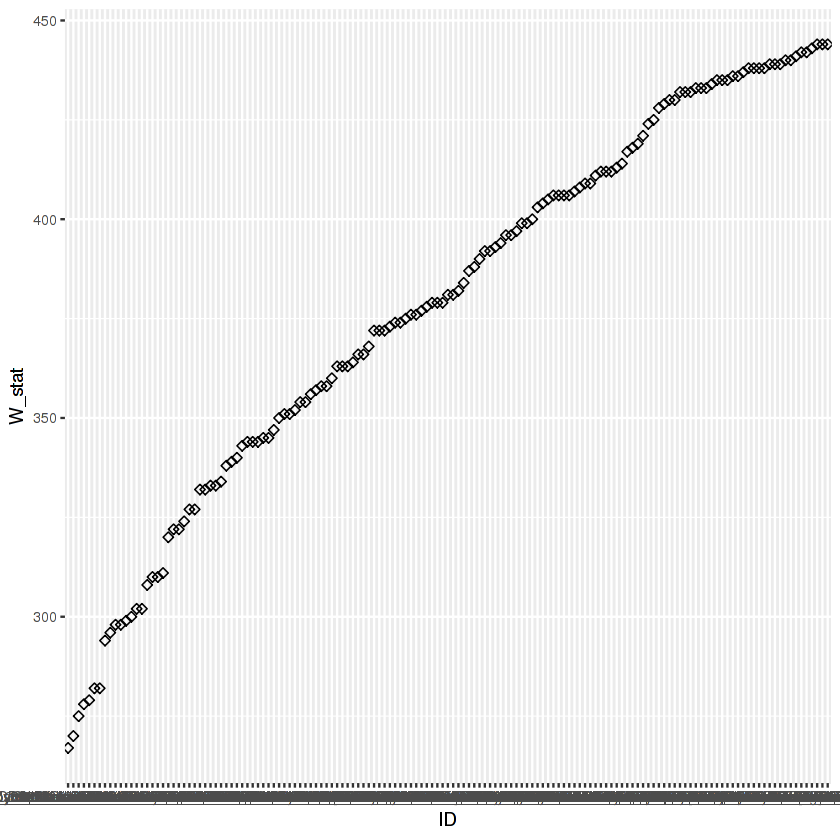

In [21]:
p = ggplot(f.fecal.ancom, aes(x=ID, y=W_stat)) +
  geom_point(size=2, shape=23)
p

### Plot siginificant DESeq results

In [5]:
library(DESeq2)

In [6]:
#Read metadata in/out to convert to mapfile for new ps object (retaining Single_MOD column)

M_abx_ctl = import_qiime_sample_data("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/DESEQ/DESEQ_mapfiles/M_abx_ctl.meta.txt")
M_abx_fmt = import_qiime_sample_data("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/DESEQ/DESEQ_mapfiles/M_abx_fmt.meta.txt")
M_ctl_fmt = import_qiime_sample_data("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/DESEQ/DESEQ_mapfiles/M_ctl_fmt.meta.txt")

F_abx_ctl = import_qiime_sample_data("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/DESEQ/DESEQ_mapfiles/F_abx_ctl.meta.txt")

fecal.abx = import_qiime_sample_data("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/DESEQ/DESEQ_mapfiles/fecal.abx.meta.txt")
fecal.control = import_qiime_sample_data("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/DESEQ/DESEQ_mapfiles/fecal.control.meta.txt")

#create new ps objects 

tree = phy_tree(alz_nt)
otu = otu_table(alz_nt)
tax = tax_table(alz_nt)

M.abx.ctl = merge_phyloseq(M_abx_ctl, tree, otu, tax)
M.abx.fmt = merge_phyloseq(M_abx_fmt, tree, otu, tax)
M.ctl.fmt = merge_phyloseq(M_ctl_fmt, tree, otu, tax)

F.abx.ctl = merge_phyloseq(F_abx_ctl, tree, otu, tax)

fecal.abx = merge_phyloseq(fecal.abx, tree, otu, tax)
fecal.ctl = merge_phyloseq(fecal.control, tree, otu, tax)



In [9]:
# Control, Abx, and F will always be positive direction of log2fold change
M.abx.ctl.dds = phyloseq_to_deseq2(M.abx.ctl, ~Treatment)
M.abx.fmt.dds = phyloseq_to_deseq2(M.abx.fmt, ~Treatment)
M.ctl.fmt.dds = phyloseq_to_deseq2(M.ctl.fmt, ~Treatment)

F.abx.ctl.dds = phyloseq_to_deseq2(F.abx.ctl, ~Treatment)

fecal.abx.dds = phyloseq_to_deseq2(fecal.abx, ~Sex)
fecal.ctl.dds = phyloseq_to_deseq2(fecal.ctl, ~Sex)

#M.abx.ctl.dds$Treatment <- relevel(M.abx.ctl.dds$Treatment, ref = "Control")

Loading required namespace: DESeq2
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode


In [13]:
#Run DESeq - fecal.ctl.dds

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans = apply(DESeq2::counts(fecal.ctl.dds), 1, gm_mean)


fecal.ctl.dds = estimateSizeFactors(fecal.ctl.dds, geoMeans = geoMeans)
fecal.ctl.dds = estimateDispersions(fecal.ctl.dds)
abund = getVarianceStabilizedData(fecal.ctl.dds)

fecal.ctl.dds = DESeq(fecal.ctl.dds, test="Wald", fitType="parametric")

res = results(fecal.ctl.dds)
res.tax = cbind(as(res, "data.frame"), as(tax_table(alz_nt)[rownames(res), ], "matrix"))

#alpha = 0.05
#sigtab = res[which(res$padj < alpha), ]
#sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(alz_nt)[rownames(sigtab), ], "matrix"))

write.csv(res.tax, file="/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/DESEQ/fecal.ctl.deseq.csv")


gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 18 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [12]:
#F.abx.ctl_0.60 = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/F_Fecal/F.abx.ctl.ancom.log2fold_0.60.csv")
#M.abx.ctl_0.60 = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/M_Fecal/M.abx.ctl.ancom.log2fold_0.60.csv")
#M.F.abx.ctl_0.60 = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/M_F.abx.ctl.ancom.log2fold_0.60.new.csv")
combined.treatments.60 = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/combined.treatments.ancom.log2fold.60.csv")
combined.treatments.70 = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/combined.treatments.ancom.log2fold.70.csv")
combined.treatments.80 = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/combined.treatments.ancom.log2fold.80.csv")
combined.treatments.90 = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/combined.treatments.ancom.log2fold.90.csv")

combined.treatments.80.v2 = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/combined.treatments.ancom.log2fold.80.order.csv")
combined.treatments.80.v3 = read.csv("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/combined.treatments.ancom.log2fold.80.logorder.csv")


In [24]:
x = combined.treatments.80.v3 %>% group_by(Treatment,Rank2,Rank3, NewIDs_4) %>% summarize(mean.log = mean(neg.log2FoldChange))
y = read.csv("/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/ancom.80.groupsort.csv")
y2 = subset(y, Treatment=!"M.abx.fmt")
y3 = subset(y2, Treatment=!"fecal.abx")


png 
  2

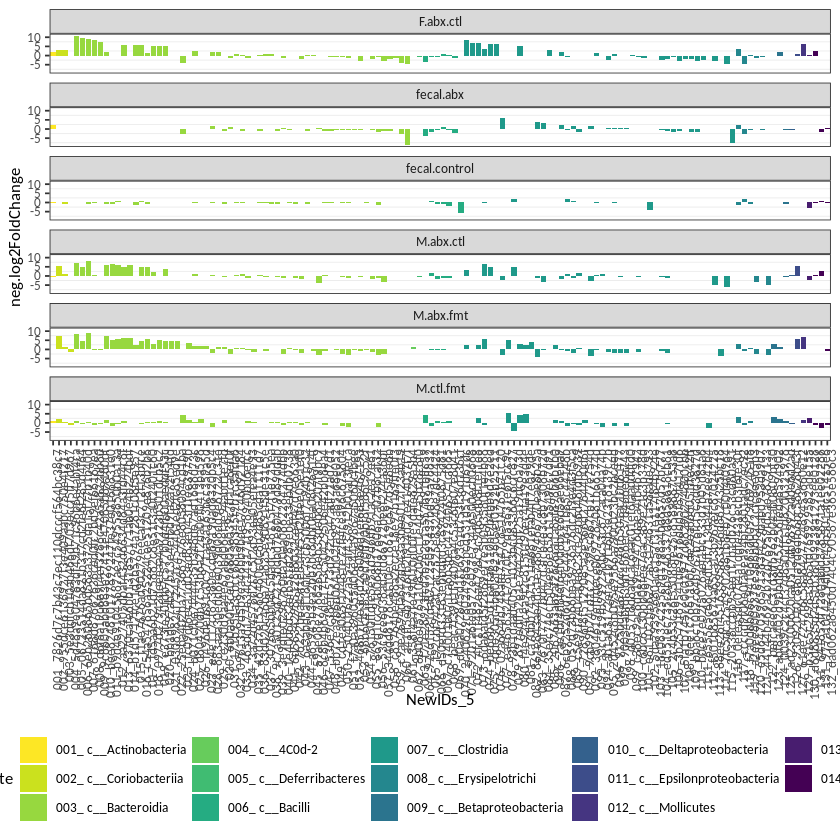

In [14]:
library(viridis)
p = ggplot(combined.treatments.80.v3, aes(x = NewIDs_5, y = neg.log2FoldChange, fill=Rank3_update)) + geom_bar(stat="identity")

p = p + scale_fill_viridis(option="viridis", discrete=TRUE, direction=-1)

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Calibri"),
                           #legend.key = element_blank(),
                           #axis.text.x = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank())#,
                           #panel.grid.minor = element_blank())

p = p + facet_wrap(~Treatment,ncol=1)

p

png('/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/Treatments.80.class_color.png', width=8, height=11, units='in', res=300)
plot(p)
dev.off()

In [19]:
library(viridis)
p = ggplot(F.abx.ctl_0.60, aes(x = TaxID, y = log2FoldChange, fill=Rank2)) + geom_bar(stat="identity")

p = p + scale_fill_viridis(option="viridis", discrete=TRUE, direction=1)

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Calibri"),
                           #legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p

png('F.abx.ctl.60.png', width=14, height=10, units='in', res=300)
plot(p)
dev.off()

ERROR: Error in ggplot(F.abx.ctl_0.60, aes(x = TaxID, y = log2FoldChange, fill = Rank2)): object 'F.abx.ctl_0.60' not found


Warning message:
“Removed 158 rows containing missing values (position_stack).”Warning message:
“Removed 158 rows containing missing values (position_stack).”

png 
  2

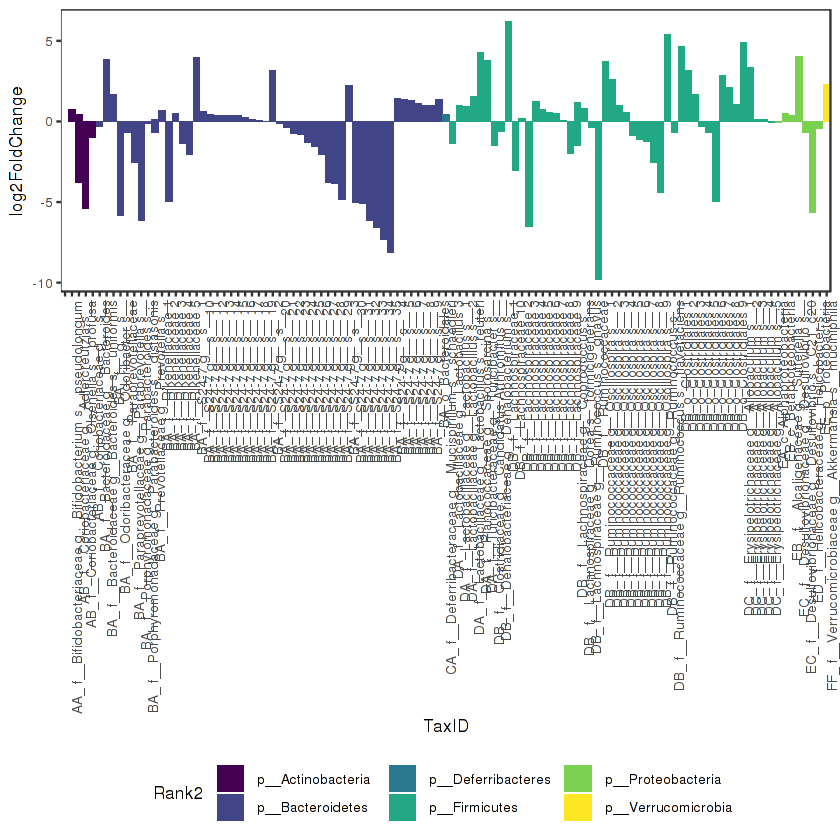

In [11]:
library(viridis)
p = ggplot(M.abx.ctl_0.60, aes(x = TaxID, y = log2FoldChange, fill=Rank2)) + geom_bar(stat="identity")

p = p + scale_fill_viridis(option="viridis", discrete=TRUE, direction=1)

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Calibri"),
                           #legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p

png('M.abx.ctl.60.png', width=14, height=10, units='in', res=300)
plot(p)
dev.off()

#### ANCOM Code from Knight Lab

In [9]:
library(exactRankTests)
library(nlme)
library(ggplot2)

ancom.W = function(otu_data,var_data,
                   adjusted,repeated,
                   main.var,adj.formula,
                   repeat.var,long,rand.formula,
                   multcorr,sig){
  
  n_otu=dim(otu_data)[2]-1
  
  otu_ids=colnames(otu_data)[-1]
  
  if(repeated==F){
    data_comp=data.frame(merge(otu_data,var_data,by="Sample.ID",all.y=T),row.names=NULL)
    #data_comp=data.frame(merge(otu_data,var_data[,c("Sample.ID",main.var)],by="Sample.ID",all.y=T),row.names=NULL)
  }else if(repeated==T){
    data_comp=data.frame(merge(otu_data,var_data,by="Sample.ID"),row.names=NULL)
   # data_comp=data.frame(merge(otu_data,var_data[,c("Sample.ID",main.var,repeat.var)],by="Sample.ID"),row.names=NULL)
  }
  
  base.formula = paste0("lr ~ ",main.var)
  if(repeated==T){
    repeat.formula = paste0(base.formula," | ", repeat.var)
  }
  if(adjusted==T){
    adjusted.formula = paste0(base.formula," + ", adj.formula)
  }
  
  if( adjusted == F & repeated == F ){
    fformula  <- formula(base.formula)
  } else if( adjusted == F & repeated == T & long == T ){
    fformula  <- formula(base.formula)   
  }else if( adjusted == F & repeated == T & long == F ){
    fformula  <- formula(repeat.formula)   
  }else if( adjusted == T & repeated == F  ){
    fformula  <- formula(adjusted.formula)   
  }else if( adjusted == T & repeated == T  ){
    fformula  <- formula(adjusted.formula)   
  }else{
    stop("Problem with data. Dataset should contain OTU abundances, groups, 
         and optionally an ID for repeated measures.")
  }
  
  
  
    if( repeated==FALSE & adjusted == FALSE){
       if( length(unique(data_comp[,which(colnames(data_comp)==main.var)]))==2 ){
          tfun <- exactRankTests::wilcox.exact
       } else{
          tfun <- stats::kruskal.test
    }
    }else if( repeated==FALSE & adjusted == TRUE){
      tfun <- stats::aov
    }else if( repeated== TRUE & adjusted == FALSE & long == FALSE){
      tfun <- stats::friedman.test
    }else if( repeated== TRUE & adjusted == FALSE & long == TRUE){
      tfun <- nlme::lme
    }else if( repeated== TRUE & adjusted == TRUE){
      tfun <- nlme::lme
    }
  
  logratio.mat <- matrix(NA, nrow=n_otu, ncol=n_otu)
  for(ii in 1:(n_otu-1)){
    for(jj in (ii+1):n_otu){
      data.pair <- data_comp[,which(colnames(data_comp)%in%otu_ids[c(ii,jj)])]
      lr <- log((1+as.numeric(data.pair[,1]))/(1+as.numeric(data.pair[,2])))
      
      lr_dat <- data.frame( lr=lr, data_comp,row.names=NULL )
      
      if(adjusted==FALSE&repeated==FALSE){  ## Wilcox, Kruskal Wallis
        logratio.mat[ii,jj] <- tfun( formula=fformula, data = lr_dat)$p.value
      }else if(adjusted==FALSE&repeated==TRUE&long==FALSE){ ## Friedman's 
        logratio.mat[ii,jj] <- tfun( formula=fformula, data = lr_dat)$p.value
      }else if(adjusted==TRUE&repeated==FALSE){ ## ANOVA
        model=tfun(formula=fformula, data = lr_dat,na.action=na.omit)   
        picker=which(gsub(" ","",row.names(summary(model)[[1]]))==main.var)  
        logratio.mat[ii,jj] <- summary(model)[[1]][["Pr(>F)"]][picker]
      }else if(repeated==TRUE&long==TRUE){ ## GEE
        model=tfun(fixed=fformula,data = lr_dat,
                   random = formula(rand.formula),
                   correlation=corAR1(),
                   na.action=na.omit)   
        picker=which(gsub(" ","",row.names(anova(model)))==main.var)
        logratio.mat[ii,jj] <- anova(model)[["p-value"]][picker]
      }
      
    }
  } 
  
  ind <- lower.tri(logratio.mat)
  logratio.mat[ind] <- t(logratio.mat)[ind]
  
  
  logratio.mat[which(is.finite(logratio.mat)==FALSE)] <- 1
  
  mc.pval <- t(apply(logratio.mat,1,function(x){
    s <- p.adjust(x, method = "BH")
    return(s)
  }))
  
  a <- logratio.mat[upper.tri(logratio.mat,diag=FALSE)==TRUE]
  
  b <- matrix(0,ncol=n_otu,nrow=n_otu)
  b[upper.tri(b)==T] <- p.adjust(a, method = "BH")
  diag(b)  <- NA
  ind.1    <- lower.tri(b)
  b[ind.1] <- t(b)[ind.1]
  
  #########################################
  ### Code to extract surrogate p-value
  surr.pval <- apply(mc.pval,1,function(x){
    s0=quantile(x[which(as.numeric(as.character(x))<sig)],0.95)
    # s0=max(x[which(as.numeric(as.character(x))<alpha)])
    return(s0)
  })
  #########################################
  ### Conservative
  if(multcorr==1){
    W <- apply(b,1,function(x){
      subp <- length(which(x<sig))
    })
    ### Moderate
  } else if(multcorr==2){
    W <- apply(mc.pval,1,function(x){
      subp <- length(which(x<sig))
    })
    ### No correction
  } else if(multcorr==3){
    W <- apply(logratio.mat,1,function(x){
      subp <- length(which(x<sig))
    })
  }
  
  return(W)
  }



ANCOM.main = function(OTUdat,Vardat,
                      adjusted,repeated,
                      main.var,adj.formula,
                      repeat.var,longitudinal,
                      random.formula,
                      multcorr,sig,
                      prev.cut){
  
  p.zeroes=apply(OTUdat[,-1],2,function(x){
    s=length(which(x==0))/length(x)
  })
  
  zeroes.dist=data.frame(colnames(OTUdat)[-1],p.zeroes,row.names=NULL)
  colnames(zeroes.dist)=c("Taxon","Proportion_zero")
  
  zero.plot = ggplot(zeroes.dist, aes(x=Proportion_zero)) + 
              geom_histogram(binwidth=0.1,colour="black",fill="white") + 
              xlab("Proportion of zeroes") + ylab("Number of taxa") +
              theme_bw()
  
  #print(zero.plot)
  
  OTUdat.thinned=OTUdat
  OTUdat.thinned=OTUdat.thinned[,c(1,1+which(p.zeroes<prev.cut))]
  
  otu.names=colnames(OTUdat.thinned)[-1]
  
  W.detected   <- ancom.W(OTUdat.thinned,Vardat,
                          adjusted,repeated,
                          main.var,adj.formula,
                          repeat.var,longitudinal,random.formula,
                          multcorr,sig)
  
  W_stat       <- W.detected
  
  
  ### Bubble plot
  
  W_frame = data.frame(otu.names,W_stat,row.names=NULL)
  W_frame = W_frame[order(-W_frame$W_stat),]
  
  W_frame$detected_0.9=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.8=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.7=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.6=rep(FALSE,dim(W_frame)[1])
  
  W_frame$detected_0.9[which(W_frame$W_stat>0.9*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.8[which(W_frame$W_stat>0.8*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.7[which(W_frame$W_stat>0.7*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.6[which(W_frame$W_stat>0.6*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  
  final_results=list(W_frame,zero.plot)
  names(final_results)=c("W.taxa","PLot.zeroes")
  return(final_results)
    }

 Package ‘exactRankTests’ is no longer under development.
 Please consider using package ‘coin’ instead.


Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

